In [206]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.3.1/en_core_web_md-2.3.1.tar.gz

     |████████████████████████████████| 50.8MB 74kB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-cp36-none-any.whl size=50916643 sha256=135d15207374464c30133067bc9877a81e50349ec20b8bc30ac51620cbad6509
  Stored in directory: /root/.cache/pip/wheels/6e/65/3a/34cdc26d4084d1d1f1e2ec9914964759ea17aa382c53a57d9f
Successfully built en-core-web-md


In [1]:
import os
import pickle

import numpy as np
import spacy

from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

*Upload submission_db.sqlite3 database*


In [2]:
from google.colab import files 
uploaded = files.upload()

Saving submission_db.sqlite3 to submission_db.sqlite3


In [41]:
import pandas as pd
import sqlite3
import numpy as np

def refresh_connection_and_cursor():
  try:
    c.close()
    conn.close()
  except: pass
  conn = sqlite3.connect('/content/submission_db.sqlite3')
  c = conn.cursor()
  return conn, c

conn, c = refresh_connection_and_cursor()

data = pd.read_sql_query(
    "select * from submission_table order by random() limit 100000;", 
    conn)

c.close()
conn.close()

In [42]:
print(data.shape)
data.head()

(99502, 5)


,subreddit_name,subreddit_id,subreddit_subs,title,text
0,UnresolvedMysteries,2wvvc,1149021,"If you suddenly disappeared right now, what mu...",Sorry for the horrible title I’m really bad at...
1,Cringetopia,ovfhp,948480,Omega Simp,
2,PS4,2rrlp,3632075,Destroy All Humans! - Remake Reveal Trailer [V...,
3,whatisthisthing,2s3kh,1788971,Water flows from a culvert beneath a trail int...,
4,Art,2qh7a,18440455,"Longing, Damian Lechoszest, Oil on Canvas, 2020",


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99502 entries, 0 to 99501
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subreddit_name  99502 non-null  object
 1   subreddit_id    99502 non-null  object
 2   subreddit_subs  99502 non-null  int64 
 3   title           99502 non-null  object
 4   text            99502 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


*Data Wrangling*

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
def warngle(df, text_len_min=100, subreddit_num=50):
  """
  df: dataframe containg the subreddits and their categories
  text_len_min: minimum length of subreddit text required to be analyzed
  statistical trimming:
  subreddit_num: sampled number of subreddit posts in each category
  """
  print("\ndf shape: ", df.shape)
  
  # filter out the rows with no significant subreddit text
  df = df[[len(i)>100 for i in df['text']]]
  print(f"\ndf shape after text length filter: {text_len_min}:")
  print(df.shape)
  # filter out the rows with low count of subreddit_ids
  subid_count = df['subreddit_id'].value_counts(ascending=False)
  
  plt.figure(figsize=(12,5))
  # y axis is density plot
  sns.distplot(subid_count, kde=False, bins=len(df['subreddit_id'].value_counts()))
  plt.title('Subreddit category histogram')
  plt.xlabel('#of posts per subreddit category')
  plt.ylabel('# of subreddit categories')

  # filter out the categories with low number of posts 
  df = df.groupby('subreddit_id').filter(
      lambda x: (x['subreddit_id'].value_counts() > subreddit_num))
  print(f"\ndf shape after dropping less than {subreddit_num} posts per category filter")
  print(df.shape)

  # converting the title and text columns to string type
  df[['title', 'text']] = df[['title', 'text']].astype('str')

  # filter out non word and non space characters.
  # lower case and remove extra spaces
  df['text'] = df['text'].str.replace("[^\w\s']",' ').str.lower().apply(lambda row: ' '.join(row.split()))
  df['title'] = df['title'].str.replace("[^\w\s']",' ').str.lower().apply(lambda row: ' '.join(row.split()))
  # print(df['text'][:10])

  # merge title and text
  df['joint_text'] = df[['title', 'text']].agg('-'.join, axis=1)
  # print(df.head())

  # Sample a fixed number of posts from each category
  df_sample = df.groupby('subreddit_id').apply(lambda x: x.sample(
      n=subreddit_num, replace=False, random_state=1))#.reset_index(drop = True)
  print(f"\ndf shape after sampling {subreddit_num} posts per subreddit category")
  print(df_sample.shape)
  
  # Number of subreddit categories to classify on
  print(f"\n# of subreddit categories: {len(df_sample['subreddit_name'].value_counts())}")

  return df, df_sample


df shape:  (99502, 5)

df shape after text length filter: 100:
(18568, 5)

df shape after dropping less than 50 posts per category filter
(17194, 5)

df shape after sampling 50 posts per subreddit category
(2900, 6)

# of subreddit categories: 58


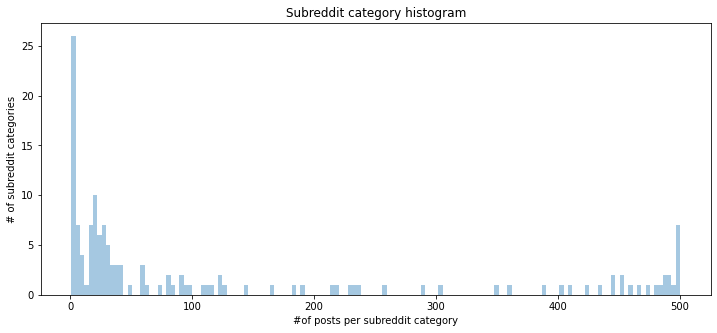

In [45]:
data, df = warngle(data, text_len_min=100, subreddit_num=50);

In [48]:
print(df.shape)
df.sample(n=5, axis=0)

(2900, 6)


,subreddit_name,subreddit_id,subreddit_subs,title,text,joint_text
2434,DestinyTheGame,2vq0w,1771547,bungie please you are sitting on a gold mine,after playing on pc i can't believe how incred...,bungie please you are sitting on a gold mine-a...
309,history,2qh53,15136105,so how did ww2 troops learn unarmed combat ski...,this a original ww2 british army training book...,so how did ww2 troops learn unarmed combat ski...
2196,summonerschool,2t9x3,467796,hey r summonerschool my brother and i created ...,hi guys rto here i have had incredible support...,hey r summonerschool my brother and i created ...
1464,legaladvice,2rawz,1348164,gf's dad filled out her mail in ballot forged ...,my girlfriend was furious not only is this obv...,gf's dad filled out her mail in ballot forged ...
2832,NintendoSwitch,3h47q,2394407,breath of the wild reminds me why i fell in lo...,being a dad now it s rare for me to get so enc...,breath of the wild reminds me why i fell in lo...


In [50]:
df['subreddit_name'].unique()

array(['VALORANT', 'apple', 'atheism', 'sex', 'help', 'books', 'history',
       'Jokes', 'Cooking', 'singapore', 'pcgaming', 'investing', 'Games',
       'Fitness', 'techsupport', 'stocks', 'relationships', 'askscience',
       'sysadmin', 'nba', 'Home', 'personalfinance', 'IAmA',
       'relationship_advice', 'TwoXChromosomes', 'cringe', 'copypasta',
       'jailbreak', 'offmychest', 'legaladvice', 'leagueoflegends',
       'buildapc', 'AskWomen', 'Twitch', 'AskMen', 'DotA2', 'LifeProTips',
       'assassinscreed', 'Instagram', 'pathofexile', 'explainlikeimfive',
       'skyrimmods', 'AskHistorians', 'summonerschool',
       'PersonalFinanceCanada', 'unpopularopinion', 'tifu', 'dndnext',
       'DestinyTheGame', 'changemyview', 'NoStupidQuestions',
       'UnresolvedMysteries', 'AmItheAsshole', 'OutOfTheLoop',
       'EscapefromTarkov', 'TheSilphRoad', 'NintendoSwitch', 'fo76'],
      dtype=object)

## Spacy Embedding

In [51]:
#Create the nlp object
nlp = spacy.load("en_core_web_md")
# Use Spacy Embedding to vectorize df['join_text']
X = pd.DataFrame([nlp(str(d)).vector for d in df['joint_text']])
y = df['subreddit_name']
X.shape,  y.shape


((2900, 300), (2900,))

In [54]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1, 
                                                    shuffle=True,
                                                    stratify=y)

X_train.shape, y_train.shape

((2320, 300), (2320,))

In [55]:
# column and row
X[0].shape, X.iloc[0].shape

((2900,), (300,))

## KNeighbors Classifier

In [59]:
from sklearn.neighbors import KNeighborsClassifier
# NearestNeighbors is the same as the classifier one but unsupervised
knn = KNeighborsClassifier(n_neighbors = 15)

# Fit the classifier to the data
knn.fit(X_train.values, y_train.values)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [60]:
knn.score(X_test.values, y_test.values)

0.2672413793103448

In [226]:
def preprocess(text, nlp):
  """
  Vectorizes the 'text' string by spacy pretrained model (nlp). 
  the return value serves as a query to the prediction model
  """
  return nlp(text).vector.reshape(1,-1)

def prediction_spacy(model, input):
  """
  return the nested list of predicted neighbors' indices from 
  the trained dataframe with their distance from the input
  input: a string type text
  """
  kn = model.kneighbors(input)
  return kn

def postprocess(kn, df_ser, n):
  """
  takes the nested list of kneighbors output (kn) and 
  returns first n recommended subreddit names.
  df_ser: pandas Series that has the class names and their respective indices
  """
  return df_ser.iloc[kn[1][0]].drop_duplicates()[:n].reset_index(drop=True)

In [101]:
query = df['joint_text'].iloc[10]
category = df['subreddit_name'].iloc[10]

print("category: {}".format(category))
print(query,"\n")

input = preprocess(query, nlp)
kn = prediction_spacy(knn, input)
pred = postprocess(kn, df['subreddit_name'], 10)
pred

category: VALORANT
accuracy reset time needs to be decreased-i have seen many discussions about this with the community mostly agreeing that accuracy recoil reset time need to be lowered but still no changes the 1s recoil reset is just a braindead concept to me as a csgo veteran now with a ton of valorant games behind me holding a site as 2 people is straight up impossible rng if they are 5 man rushing as transitioning from one target to another if you shot multiple rounds will just mean you have to wait a time during which they definetly kill you or have an aim like you are running whenever these technical arguments came up about the csgo valorant mechanincs the arguments are that valorant doesn't have to be like csgo it's more accesable team focused less focused on god like aim now what the high accuracy reset time creates doesn't even seem to stand up to these standards it is highly frustrating to see that you haven't shot for a time and your crosshair reseted position and everythin

0              DotA2
1           AskWomen
2          Instagram
3          singapore
4         skyrimmods
5             stocks
6    leagueoflegends
7          copypasta
8     summonerschool
9    TwoXChromosomes
Name: subreddit_name, dtype: object

In [102]:
df['joint_text'].iloc[kn[1][0]]

1788    my country lebanon literally exploded today-i ...
1635    that friend of yours that s always single what...
1930    my posts are dying-so guys i'm a photographer ...
463     so i heard a loud bang outside my flat this mo...
451     a message to parents with schoolchildren from ...
2079    request pc sse mod that randomly plays dialogu...
791     stock trading halted for 15 minutes after the ...
1538    sk telecom t1 vs misfits 2017 world championsh...
1308    greta thunberg is the reason i work out-greta ...
2172    nathan mott is a jg coach who uploads all his ...
1525    pobelter for the first time since season 4 i w...
1214    my grandfather who raised me passed away being...
1424    my girlfriend gave me sunflowers and made me c...
157     sex has changed my girlfriend's life-my girlfr...
936     update to i accepted a new job offer and my em...
Name: joint_text, dtype: object

In [103]:
user_input = """Wildfires sweeping through the West Coast killed at least 36 people, CNN reports
- The fires have burned across a total of some 4.5 million acres (1.8 million hectares) in Oregon, California, Washington and Idaho, according to Reuters
- Wildfires are causing dangerous air quality and emitting record amounts of carbon dioxide"""

input = preprocess(user_input, nlp)
kn = prediction_spacy(knn, input)
pred = postprocess(kn, df['subreddit_name'], 5)
pred

0               IAmA
1               Home
2    TwoXChromosomes
3               help
4           AskWomen
Name: subreddit_name, dtype: object

In [104]:
df['joint_text'].iloc[kn[1][0][:5]]

1149    i'm the brofessor and author of the swoly bibl...
1010    what do you use on your drains-hey all i'm cur...
1245    found read my stepdad s journal-so a few month...
212     i cannot post images on any subreddits and i d...
1617    why do you push people away-have you ever push...
Name: joint_text, dtype: object

## Model Serialization

In [92]:
import pickle
# pickle knn model
knnPickle = open('knnpickle', 'wb') 
pickle.dump(knn, knnPickle)   

# pickle the dataframe
df['subreddit_name'].to_pickle("./namedf.pkl")

# nlp pickle
nlpPickle = open('nlppickle', 'wb') 
pickle.dump(nlp, nlpPickle) 

In [94]:
loaded_model = pickle.load(open('knnpickle', 'rb'))
loaded_nlp = pickle.load(open('nlppickle', 'rb'))
loaded_df = pd.read_pickle("./namedf.pkl")

In [108]:
input = preprocess(user_input, loaded_nlp)
kn = prediction_spacy(loaded_model, input)
pred = postprocess(kn, loaded_df, 5)
pred

0               IAmA
1               Home
2    TwoXChromosomes
3               help
4           AskWomen
Name: subreddit_name, dtype: object

## Latent Semantic Indexing (LSI)

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

In [110]:
# Create Pipeline Components

vect = TfidfVectorizer( stop_words='english', 
                       ngram_range=(1,2),
                       lowercase=True,
                       max_df=0.9,
                       min_df=1,
                       max_features=None)

svd = TruncatedSVD(n_components=100, # Just here for demo. 
                   algorithm='randomized',
                   n_iter=10, random_state=1)

rfc = RandomForestClassifier()

In [112]:
lsi = Pipeline([('vect', vect), ('svd', svd)])
pipe = Pipeline([('lsi', lsi), ('clf', rfc)])

In [113]:
parameters = {
    'lsi__vect__max_df': ( 0.75, 1.0),
    'lsi__vect__min_df': (.02, .05),
    'lsi__vect__max_features': (500,1000),
    'lsi__svd__n_components': [10,100,250],
    'clf__n_estimators':(5, 10,),
    'clf__max_depth':(15,20)
}

grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=7, verbose=1)

In [114]:
grid_search.fit(df['joint_text'], y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  7.8min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 18.9min
[Parallel(n_jobs=7)]: Done 480 out of 480 | elapsed: 21.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lsi',
                                        Pipeline(memory=None,
                                                 steps=[('vect',
                                                         TfidfVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='strict',
                                                                         dtype=<class 'numpy.float64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=0.9,
             

In [115]:
# The accuracy is less that spacy vectorizer
grid_search.best_score_

0.20275862068965517

In [121]:
grid_search.predict([user_input])

array(['investing'], dtype=object)

In [203]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('lsi',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=1000,
                                                  min_df=0.02,
                                                  ngram_range=(1, 2), norm='l2',
                                                  preprocessor=None,
                                                  smooth_idf=True,
                                                  stop_words='english',
    

In [236]:
def prediction_est(model, input):
  """
  input: text string or list as input
  model: grid search trained model
  returns a pandas series containing the the recommended subreddit names
  """
  if isinstance(input, str):
    input = [input]
  # probability of each class
  proba = model.predict_proba(input)

  # index of the highest probable classes in descending order
  index_proba = [i[0] for i in sorted(enumerate(proba[0]), key=lambda x:x[1])][::-1]
  # Alternative way
  # idx_max = proba[0].argsort()[::-1]

  # get the most probable class names
  return pd.Series(model.classes_[index_proba][:15])

In [239]:
prediction_est(grid_search, user_input)

0                 investing
1                   atheism
2     PersonalFinanceCanada
3                 copypasta
4         explainlikeimfive
5                askscience
6            NintendoSwitch
7                  sysadmin
8                     Jokes
9              changemyview
10                 AskWomen
11             TheSilphRoad
12                jailbreak
13          personalfinance
14                singapore
dtype: object

In [166]:
# pickle grid search model with rfc+lsi
rfclsi = open('rfclsi_pickle', 'wb') 
pickle.dump(grid_search, rfclsi)   

In [200]:
loaded_model = pickle.load(open('rfclsi_pickle', 'rb'))

In [202]:
prediction_est(loaded_model, user_input)

0                 investing
1                   atheism
2     PersonalFinanceCanada
3                 copypasta
4         explainlikeimfive
5                askscience
6            NintendoSwitch
7                  sysadmin
8                     Jokes
9              changemyview
10                 AskWomen
11             TheSilphRoad
12                jailbreak
13          personalfinance
14                singapore
dtype: object

### Gradient Boost Classifier:

In [204]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from scipy.stats import randint
from sklearn.preprocessing import FunctionTransformer

In [207]:
import spacy
nlp = spacy.load("en_core_web_md")

* Spacy vectorizer

In [208]:
# def get_word_vectors(docs):
#     return np.array([nlp(doc).vector for doc in docs])

In [209]:
# Instantiate the spacy vectorizer
# embed = FunctionTransformer(get_word_vectors)

In [210]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                               subsample=1.0, criterion='friedman_mse', min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                               max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, 
                               init=None, random_state=None, max_features=None, verbose=0, 
                               max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                               validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)


In [219]:
# spacy embedding is taken out of the pipeline to save time
pipe = Pipeline([
#     ('emb', embed), 
    ('clf', gbc)
    ])

In [220]:
# Gradient Boost Classifier
gbc_par_names = ["max_features", "max_depth", "min_samples_split", "min_samples_leaf"]

max_features_gbc = np.arange(2,30,2)
max_depth_gbc = range(2,16,2)
min_samples_split_gbc = np.linspace(2, 40, 10, endpoint=True).astype(int)
min_samples_leaf_gbc = np.linspace(2, 40, 10, endpoint=True).astype(int)
criterion_gbc = ["gini", "entropy"]
gbc_param_ranges = [max_features_gbc, max_depth_gbc, min_samples_split_gbc, min_samples_leaf_gbc]

param_dist = {
    'clf__max_features': max_features_gbc, 
    'clf__max_depth': max_depth_gbc, 
    'clf__min_samples_split': min_samples_split_gbc, 
    'clf__min_samples_leaf': min_samples_leaf_gbc
    }

In [221]:
rscv = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=2, cv=2, verbose=1, n_jobs=-1)

In [222]:
rscv.fit(X, y)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.5min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('clf',
                                              GradientBoostingClassifier(ccp_alpha=0.0,
                                                                         criterion='friedman_mse',
                                                                         init=None,
                                                                         learning_rate=0.1,
                                                                         loss='deviance',
                                                                         max_depth=3,
                                                                         max_features=None,
                                                                         max_leaf_nodes=None,
                                                                         min_impurity_decrease=0.0,
                             

In [223]:
print(rscv.best_score_)
rscv.best_estimator_

0.38172413793103444


Pipeline(memory=None,
         steps=[('clf',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=12, max_features=14,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=35,
                                            min_samples_split=23,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            presort='deprecated',
                                            random_sta

In [224]:
# pickle randomized searchCV model with gbc+nlp
gbnlp = open('gbnlp_pickle', 'wb') 
pickle.dump(rscv, gbnlp)   

In [225]:
loaded_model = pickle.load(open('gbnlp_pickle', 'rb'))

In [229]:
input = preprocess(user_input, loaded_nlp)
input.shape

(1, 300)

In [230]:
X.shape

(2900, 300)

In [240]:
input = preprocess(user_input, loaded_nlp)
pred = prediction_est(loaded_model, input)
pred

0                 investing
1                    stocks
2                       nba
3             AskHistorians
4                askscience
5                 copypasta
6                   history
7                   atheism
8                      Home
9                    Twitch
10                  dndnext
11        explainlikeimfive
12                     IAmA
13    PersonalFinanceCanada
14      UnresolvedMysteries
dtype: object